In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from time import time
from decimal import Decimal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

# Import training data

In [2]:
### import ref failures
tic = time()

rf_signals = pd.read_excel('./Training/all_fail/ref_failures_ATData.xlsx')
rf_bubble_detect = pd.read_excel('./Training/all_fail/ref_failures_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 447.838s


In [3]:
### import ref bubbles
tic = time()

LT_rb_signals = pd.read_excel('./Training/all_bubbles/ref_bubbles_ATData.xlsx')
LT_rb_bubble_detect = pd.read_excel('./Training/all_bubbles/ref_bubbles_BubbleDetectTime.xlsx')

FG_rb_signals = pd.read_excel('./Training/FG_bubbles/FG_ref_bubbles_ATData.xlsx')
FG_rb_bubble_detect = pd.read_excel('./Training/FG_bubbles/FG_ref_bubbles_BubbleDetectTime.xlsx')

rb_signals = pd.concat([LT_rb_signals, FG_rb_signals])
rb_bubble_detect = pd.concat([LT_rb_bubble_detect, FG_rb_bubble_detect])

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 25.489s


In [4]:
### import normal tests
tic = time()

for i in range(1, 5):
    signals_file = f"./Training/BUN_normal/ATData/{i}.xlsx"
    n_signals = f"n_signals_{i}"
    
    bubble_detect_file = f"./Training/BUN_normal/BubbleDetectTime/{i}.xlsx"
    n_bubble_detect = f"n_bubble_detect_{i}"
    
    globals()[n_signals] = pd.read_excel(signals_file)
    globals()[n_bubble_detect] = pd.read_excel(bubble_detect_file)

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 966.454s


In [5]:
### import FG normal tests ONLY
tic = time()

FG_n_signals = pd.read_excel('./Training/FG_normal/FG_normal_ATData.xlsx')
FG_n_bubble_detect = pd.read_excel('./Training/FG_normal/FG_normal_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 121.628s


In [6]:
### concatenating normal tests
n_signals = pd.concat([n_signals_1, n_signals_2, n_signals_3, n_signals_4, FG_n_signals])
n_bubble_detect = pd.concat([n_bubble_detect_1, n_bubble_detect_2, n_bubble_detect_3, n_bubble_detect_4, FG_n_bubble_detect])

# Import testing data

In [2]:
### import ref failures
tic = time()

rf_signals = pd.read_excel('./Testing/ref_failures/ref_failures_ATData.xlsx')
rf_bubble_detect = pd.read_excel('./Testing/ref_failures/ref_failures_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 62.174s


In [3]:
### import ref bubbles
tic = time()

rb_signals = pd.read_excel('./Testing/ref_bubbles/ref_bubbles_ATData.xlsx')
rb_bubble_detect = pd.read_excel('./Testing/ref_bubbles/ref_bubbles_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 3.491s


In [4]:
### import normal tests
tic = time()

for i in range(5, 6): # upper range should be 9
    signals_file = f"./Training/BUN_normal/ATData/{i}.xlsx"
    n_signals = f"n_signals_{i}"
    
    bubble_detect_file = f"./Training/BUN_normal/BubbleDetectTime/{i}.xlsx"
    n_bubble_detect = f"n_bubble_detect_{i}"
    
    globals()[n_signals] = pd.read_excel(signals_file)
    globals()[n_bubble_detect] = pd.read_excel(bubble_detect_file)

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 303.447s


In [5]:
### selection normal test samples
n_signals = n_signals_5
n_bubble_detect = n_bubble_detect_5

In [6]:
print(len(rf_signals)/3)
print(len(rf_bubble_detect))

print(len(rb_signals)/3)
print(len(rb_bubble_detect))

print(len(n_signals)/3)
print(len(n_bubble_detect))

431.0
431
25.0
25
1707.0
1707


# Create test objects and dataframe

In [7]:
class Test:
    def __init__(self, ID, BubbleDetectTime, P4, P5, A4):
        self.ID = ID
        self.BubbleDetectTime = BubbleDetectTime
        self.P4 = P4 # potassium
        self.P5 = P5 # calcium
        self.A4 = A4 # crea
        
    # function to offset t = 0
    def offset_time(self):
        # using Decimal due to rounding error
        t_0 = Decimal(str(self.BubbleDetectTime + 30))
        t_step = Decimal(str(0.2))
        start_idx = round(t_0/t_step) - 1
                
        self.P4 = self.P4[start_idx:]
        self.P5 = self.P5[start_idx:]
        self.A4 = self.A4[start_idx:]
        
    # function to trim NaNs
    def trim_NaNs(self):
        # making sure list is not empty
        while len(self.P4) > 0 and math.isnan(self.P4[-1]):
            self.P4.pop()
                
        while len(self.P5) > 0 and math.isnan(self.P5[-1]):
            self.P5.pop()
        
        while len(self.A4) > 0 and math.isnan(self.A4[-1]):
            self.A4.pop()
            

def create_test_list(signals, bubble_detect_time):
    # separating channels
    group_channels = signals.groupby('Channel')
    channel_dfs = {}

    # iterating over the groups and creating a new dataframe for each group
    for channel, group in group_channels:
        df = pd.DataFrame(group.iloc[:, 2:])
        channel_dfs[channel] = df

    # creating test objects
    tests = []
    for i in range(0, len(bubble_detect_time)):
        ID = bubble_detect_time.iloc[i, 0]
        BubbleDetectTime = bubble_detect_time.iloc[i, 1]
        P4 = channel_dfs['P4'].iloc[i, :].values.tolist()
        P5 = channel_dfs['P5'].iloc[i, :].values.tolist()
        A4 = channel_dfs['A4'].iloc[i, :].values.tolist()

        new_test = Test(ID, BubbleDetectTime, P4, P5, A4)
        tests.append(new_test)
    
    return tests

In [8]:
### making test objects for each test type
labels = ["Normal", "Ref failure", "Ref bubble"]
signals = [n_signals, rf_signals, rb_signals]
bubble_detect_times = [n_bubble_detect, rf_bubble_detect, rb_bubble_detect]

test_dict = {}

for label, signal, bubble_detect_time in zip(labels, signals, bubble_detect_times):
    test_dict[label] = create_test_list(signal, bubble_detect_time)

### offset and trim all tests
for test_type in test_dict.values():
    for idx, test in enumerate(test_type): 
        test.offset_time()
        test.trim_NaNs()
        
n_tests = test_dict["Normal"]
rf_tests = test_dict["Ref failure"]
rb_tests = test_dict["Ref bubble"]

In [9]:
print(len(n_tests))
print(len(rf_tests))
print(len(rb_tests))

10050
2706
307


In [10]:
### labelling tests

# creating new dataframes with class and predicted class for each test - note: this makes the value type np.int32
n_df = pd.DataFrame({'Test': n_tests, 'Class': np.repeat(0, len(n_tests)), 'Predicted': ''})
rf_df = pd.DataFrame({'Test': rf_tests, 'Class': np.repeat(1, len(rf_tests)), 'Predicted': ''})
rb_df = pd.DataFrame({'Test': rb_tests, 'Class': np.repeat(2, len(rb_tests)), 'Predicted': ''})

# concatenating
test_df = pd.concat([n_df, rf_df, rb_df]).reset_index(drop=True)

# list of tests that have no data after offsetting and removing NaNs (i.e. too short)
short_tests = [9948792,9948793,9948801,10053185,10616713]

# list of all TestIDs that were mislabelled BINARY N/RF ONLY
mislabelled_IDs = [9938538,10156680,9925364,9925365,9925366,9925372,9930007,9936122,9938269,9938374,9940434,9940579,9948565,
                   9948808,9976467,9979141,9990178,9990296,9938596,9987550,10016424,10017306,10017317,10018494,10018535,10018609,
                   10019934,10020102,10020118,10032447,10037336,10037557,10045983,10050257,10052220,10053192,10053197,10055126,
                   10055522,10092143,10093215,10093219,10093244,10099978,10099988,10141397,10141399,10144297,10156758,10161679,
                   10161848,10162232,10209158,10209160,10209340,10209347,10209351,10209615,10210158,10210166,10212789,10212816,
                   10216677,10216792,10216948,10217218,10217373,10222336,10222367,10230372,10230503,10230647,10230736,10230861,
                   10231582,10235570,10300110,10300128,10300436,10303517,10324466,10324863,10326050,10326154,10331129,10331645,
                   10331649,10331655,10331682,10351954,10352005,10353310,10353757,10353844,10366986,10367003,10367312,10367314,
                   10368483,10368573,10368599,10371167,10393545,10393678,10393679,10393684,10393688,10398049,10399520,10399548,
                   10399592,10399603,10399606,10444796,10444826,10444850,10445377,10445390,10445467,10447550,10447578,10450845,
                   10473452,10473483,10473498,10474543,10474550,10474802,10477552,10477668,10477673,10477844,10477883,10477893,
                   10479485,10479621,10516528,10516801,10517397,10517537,10521862,10521874,10522228,10522324,10538397,10539869,
                   10540000,10540011,10543357,10543456,10545373,10566923,10566988,10570600,10572212,10572235,10572578,10572595,
                   10612613,10612786,10616681,10617184,10619471,10619563,10084427,10318971,10345699,10156868,10318959,10345692,
                   10637720,10639340,10639356,10639375,10658664,10658673,10658679,10658695,10658707,10661264,10661379,10679756,
                   10682362,10682367,10682785,10730144,10731308,10744370,10744443,10744533,10744534,10751336,10766517]

# rb = 9925278, 9976872, 10017313, 10017528, 10413109, 10834433 NOT ADDED!!!

rb_n = [9976872,10017528,10413109,10834433]
rb_rf = [10017313]

print(len(test_df))

# cleaning up
for test in test_df['Test']:
    # removing short tests
    if test.ID in short_tests:
        mask = test_df['Test'] == test
        test_df.drop(index=test_df[mask].index, inplace=True)
        test_df.reset_index(drop=True, inplace=True)
        
    # relabelling mislabelled tests
    if test.ID in mislabelled_IDs:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = abs(1 - test_df.loc[mask, 'Class'])
        
    # fixing normal tests labelled as ref bubbles
    if test.ID in rb_n:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = 0
        
    # fixing ref failures labelled as ref bubbles
    if test.ID in rb_rf:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = 1
        
print(len(test_df))

13063
13058


In [24]:
"""print(len(n_df))
print(len(rf_df))
print(len(rb_df))

print(len(test_df))"""

6922
2706
201
                                             Test  Class Predicted
0    <__main__.Test object at 0x000001D6B4D7D040>      2          
1    <__main__.Test object at 0x000001D6B4D780D0>      2          
2    <__main__.Test object at 0x000001D6B4D78190>      2          
3    <__main__.Test object at 0x000001D6B4D5F9A0>      2          
4    <__main__.Test object at 0x000001D843ED3F40>      2          
..                                            ...    ...       ...
196  <__main__.Test object at 0x000001D721A680D0>      2          
197  <__main__.Test object at 0x000001D721A68220>      2          
198  <__main__.Test object at 0x000001D721A68280>      2          
199  <__main__.Test object at 0x000001D721A682E0>      2          
200  <__main__.Test object at 0x000001D721A68340>      2          

[201 rows x 3 columns]


In [11]:
### KEY FUNCTIONS

# function to find small peaks for one LONG test
def small_peaks(test):    
    # checking for valleys
    peaks, _ = find_peaks(-1*np.array(test.P4), width=10) 
    
    # checking for peaks
    if len(peaks) == 0:
        peaks, _ = find_peaks(np.array(test.P4), width=10) 
    
    # checking number of peaks
    if len(peaks) >= 10: # ref bubble
        # print("len(peaks) = ", str(len(peaks)))
        return 3
    elif 5 < len(peaks) < 10: # ref bubble OR ref failure
        # print("len(peaks) = ", str(len(peaks)))
        return 2
    elif 0 < len(peaks) <= 5: # normal test OR ref failure
        # print("len(peaks) = ", str(len(peaks)))
        return 1
    else:
        # print("len(peaks) = ", str(len(peaks)))
        return 0 # no peaks --> undetermined
    

# function to find wide peaks for one LONG test
def wide_peaks(test):
    # checking for valleys
    peaks, _ = find_peaks(-1*np.array(test.P4), width=250) 
    
    # checking for peaks
    if len(peaks) == 0:
        peaks, _ = find_peaks(np.array(test.P4), width=250) 
    
    return peaks


# function to find (short) peaks for one SHORT TEST. size = width of peaks
def short_peaks(test, size):
    if size == 0:
        # checking for valleys
        peaks_1, _ = find_peaks(-1*np.array(test.P4))

        # checking for peaks
        peaks_2, _ = find_peaks(np.array(test.P4)) 

        # merging valleys and peaks
        peaks = np.concatenate((peaks_1, peaks_2))

        if len(peaks) >= 80: # normal 
            return 1
        else: # undetermined
            return 0
        
    elif size == 10:
        # checking for valleys
        peaks_1, _ = find_peaks(-1*np.array(test.P4), width=size)

        # checking for peaks
        peaks_2, _ = find_peaks(np.array(test.P4), width=size) 

        # merging valleys and peaks
        peaks = np.concatenate((peaks_1, peaks_2))

        if len(peaks) >= 3: # ref bubble 
            return 1
        else: # undetermined
            return 0


# define the polynomial function to fit
def poly_func(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


# fit data to polynomial curve for one test
def fit_poly(test):
    y = test.P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 6 coefficients rather than passing an array

    return x, y, y_fit, popt


# define the linear function to fit
def lin_func(x, a, b):
    return a*x + b


# fit data to linear curve for one test
def fit_lin(test):
    y = test.P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 2 coefficients rather than passing an array

    return x, y, y_fit, popt


# plot waveforms with peaks for list of tests
def plot_waveforms(target_indices, tests, test_peaks):
    n_plots = len(target_indices)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for axs_num, idx in enumerate(target_indices):
        P4_array = np.array(tests[idx].P4)
        peaks = test_peaks[idx]
        
        # plotting waveforms with peaks
        axs[axs_num].plot(P4_array)
        axs[axs_num].plot(peaks, P4_array[peaks], "x")
        axs[axs_num].tick_params(axis='both', which='major', labelsize=8)

    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()


# plot data and fit function for one test
def plot_fit(x, y, y_fit):
    # create plot
    plt.scatter(x, y, marker='o', s=0.05, label='Data')
    plt.plot(x, y_fit, color='red', label='Fit')        
    plt.show()
        

# compute residuals for one test
def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared


# average confusion matrices
def average_matrices(matrices):
    # get the shape of the first matrix in the list
    rows, cols = matrices[0].shape

    # initialize a matrix for sum
    sum_matrix = np.zeros((rows, cols))

    # iterate over each matrix in the list and add corresponding elements
    for matrix in matrices:
        sum_matrix += matrix

    # calculate the average by dividing by the total number of matrices
    avg_matrix = sum_matrix / len(matrices)
    
    # rounding
    avg_matrix = np.around(avg_matrix, decimals=1)

    return avg_matrix

In [201]:
"""### predictions for random samples

x = 10
reports = []
class_labels = ['Normal', 'Ref failure', 'Ref bubble']

# randomly sample and compute accuracy and precision x times
for i in range(0, x):
    sampled_df = test_df.sample(n=1000).reset_index(drop=True) # subset of original dataframe
    """sample_peaks = flag_peaks_2(sampled_df['Test'].values.tolist())
    target_indices = list(range(len(sampled_df['Test']))) # all
    plot_waveforms(target_indices, sampled_df['Test'].values.tolist(), sample_peaks)"""

    # processing each test in sample
    for idx, test in enumerate(sampled_df['Test']):
        sm_flag = small_peaks(test)
        
        # if at least 10 peaks
        if(sm_flag == 3):
            sampled_df.loc[idx, 'Predicted'] = 2 # ref bubble
            # print("ref bubble; >10 small peaks")

        # if between 5 and 10 peaks
        elif(sm_flag == 2):
            wd_flag = len(wide_peaks(test))
            if(wd_flag > 0):
                sampled_df.loc[idx, 'Predicted'] = 1 # ref failure
                # print("ref failure; between 5 and 10 small peaks, some wide peaks")
            else:
                sampled_df.loc[idx, 'Predicted'] = 2 # ref bubble
                # print("ref bubble; between 5 and 10 small peaks, no wide peaks")

        # if no peak detected 
        elif(sm_flag == 0):
            # fit to LINEAR function
            x, y, y_fit, popt = fit_lin(test)

            # check if slope is positive
            if popt[0] > 0:
                sampled_df.loc[idx, 'Predicted'] = 2 # ref bubble
                # print("ref bubble; no peaks, slope is positive")
            else:
                sampled_df.loc[idx, 'Predicted'] = 0 # normal
                # print("normal; no peaks, slope is negative")

        # somewhere between 0 and 5 peaks --> this filtering should be very similar to prior
        else:
            # fit to LINEAR function
            x, y, y_fit, popt = fit_lin(test)

            # compute R-squared value
            r_squared = compute_residuals(y, y_fit)

            # check if slope is positive & fit is strong
            if (popt[0] > 0) & (r_squared > 0.9500):
                sampled_df.loc[idx, 'Predicted'] = 2 # ref bubble
                # print("ref bubble; few peaks, positive slope and strong linear fit")
            else:
                # fit to POLYNOMIAL curve
                x, y, y_fit, popt = fit_poly(test)

                # compute R-squared value
                r_squared = compute_residuals(y, y_fit)

                # check with threshold
                if r_squared > 0.9975:
                    sampled_df.loc[idx, 'Predicted'] = 0 # normal
                    # print("normal; few peaks, strong polynomial fit")
                else:
                    sampled_df.loc[idx, 'Predicted'] = 1 # ref failure
                    # print("ref failure; few peaks, weaker polynomial fit")
                        
    # getting targets and predictions for sample
    sample_targets = sampled_df['Class']
    sample_predictions = sampled_df['Predicted'].astype(np.int32) # convert to match Class type
    
    # classification report for each sample
    sample_report = classification_report(sample_targets, sample_predictions, target_names=class_labels, output_dict=True)
    reports.append(sample_report)"""

In [202]:
"""### evaluate predictions
metric_labels = ['precision', 'recall', 'f1-score', 'support']

precision_scores = {'Normal': [], 'Ref failure': [], 'Ref bubble': []}
recall_scores = {'Normal': [], 'Ref failure': [], 'Ref bubble': []}
f1_scores = {'Normal': [], 'Ref failure': [], 'Ref bubble': []}
support_scores = {'Normal': [], 'Ref failure': [], 'Ref bubble': []}

# collect scores for each metric
for report in reports:
    for class_label in class_labels:
        precision_scores[class_label].append(report[class_label]['precision'])
        recall_scores[class_label].append(report[class_label]['recall'])
        f1_scores[class_label].append(report[class_label]['f1-score'])
        support_scores[class_label].append(report[class_label]['support'])
        
# calculate averages for each metric
averages = {}
for class_label in class_labels:
    class_averages = {}
    for metric_label in metric_labels:
        scores = {
            'precision': precision_scores[class_label],
            'recall': recall_scores[class_label],
            'f1-score': f1_scores[class_label],
            'support': support_scores[class_label]
        }
        average_score = sum(scores[metric_label]) / len(scores[metric_label])
        class_averages[metric_label] = average_score
    averages[class_label] = class_averages

# print averages for each class and metric
for class_label in class_labels:
    print(f"{class_label} tests:")
    class_averages = averages[class_label]
    for metric_label, average_score in class_averages.items():
        if metric_label == 'support':
            print(f"Average {metric_label}: {int(average_score)}")
        else:
            print(f"Average {metric_label}: {round(average_score * 100, 1)}%")
    print()"""

Normal tests:
Average precision: 98.5%
Average recall: 99.4%
Average f1-score: 99.0%
Average support: 682

Ref failure tests:
Average precision: 98.4%
Average recall: 96.5%
Average f1-score: 97.4%
Average support: 286

Ref bubble tests:
Average precision: 95.9%
Average recall: 94.8%
Average f1-score: 95.3%
Average support: 31



In [12]:
### SHORT PIPELINE
def run_short(idx, test, test_df):
    # checking for peaks of width=0
    sh_flag = short_peaks(test, 0)
    
    # if at least 80 peaks
    if sh_flag == 1:
        test_df.loc[idx, 'Predicted'] = 0 # short normal
        # print("short normal; >= 80 peaks")
    else:
        # checking for peaks of width=10
        sh_flag = short_peaks(test, 10)
    
        # if at least 3 peaks
        if sh_flag == 1:
            test_df.loc[idx, 'Predicted'] = 2 # short ref bubble
            # print("short ref bubble; >= 3 peaks")

        # less than 3 peaks
        else:
            # fit to LINEAR function
            x, y, y_fit, popt = fit_lin(test)

            # compute R-squared value
            r_squared = compute_residuals(y, y_fit)

            # check with soft threshold
            if r_squared > 0.989249:
                test_df.loc[idx, 'Predicted'] = 0 # short normal
                # print("short normal; <3 peaks, strong linear fit")
            elif r_squared < 0.979945:
                test_df.loc[idx, 'Predicted'] = 2 # short ref bubble
                # print("short ref bubble; <3 peaks, weaker linear fit")
            else: # in ambiguous region
                test_df.loc[idx, 'Predicted'] = -1 # ambiguous
                # check with hard threshold
                if r_squared >= 0.9850:
                    test_df.loc[idx, 'Comments'] = "Suspected normal test (short)"
                else:
                    test_df.loc[idx, 'Comments'] = "Suspected ref bubble (short)"

                
### LONG PIPELINE
def run_long(idx, test, test_df):
    sm_flag = small_peaks(test)
        
    # if at least 10 peaks
    if sm_flag == 3:
        test_df.loc[idx, 'Predicted'] = 2 # ref bubble
        # print("ref bubble; >=10 small peaks")
    
    # if between 5 and 10 peaks
    elif sm_flag == 2:
        wd_flag = len(wide_peaks(test))
        if wd_flag > 0:
            test_df.loc[idx, 'Predicted'] = 1 # ref failure
            # print("ref failure; between 5 and 10 small peaks, some wide peaks")
        else:
            test_df.loc[idx, 'Predicted'] = 2 # ref bubble
            # print("ref bubble; between 5 and 10 small peaks, no wide peaks")

    # if no peak detected 
    elif sm_flag == 0:
        # fit to LINEAR function
        x, y, y_fit, popt = fit_lin(test)

        # check if slope is positive
        if popt[0] > 0:
            test_df.loc[idx, 'Predicted'] = 2 # ref bubble
            # print("ref bubble; no peaks, slope is positive")
        else:
            test_df.loc[idx, 'Predicted'] = 0 # normal
            # print("normal; no peaks, slope is negative")

    # somewhere between 0 and 5 peaks --> this filtering should be very similar to prior
    else:
        # fit to LINEAR function
        x, y, y_fit, popt = fit_lin(test)
        
        # compute R-squared value
        r_squared = compute_residuals(y, y_fit)

        # check if slope is positive & fit is strong
        if (popt[0] > 0) & (r_squared > 0.9500):
            test_df.loc[idx, 'Predicted'] = 2 # ref bubble
            # print("ref bubble; few peaks, positive slope and strong linear fit")
        else:
            # fit to POLYNOMIAL curve
            x, y, y_fit, popt = fit_poly(test)

            # compute R-squared value
            r_squared = compute_residuals(y, y_fit)

            # check with soft threshold
            if r_squared > 0.999286:
                test_df.loc[idx, 'Predicted'] = 0 # normal
                # print("normal; few peaks, strong polynomial fit")
            elif r_squared < 0.994845:
                test_df.loc[idx, 'Predicted'] = 1 # ref failure
                # print("ref failure; few peaks, weaker polynomial fit")
            else: # in ambiguous region
                test_df.loc[idx, 'Predicted'] = -1 # ambiguous
                # check with hard threshold
                if r_squared > 0.9970:
                    test_df.loc[idx, 'Comments'] = "Suspected normal test (long)"
                else:
                    test_df.loc[idx, 'Comments'] = "Suspected ref failure (long)"

In [13]:
### adding comments column to test_df for ambiguous tests
test_df['Comments'] = ''
test_df.head()

,Test,Class,Predicted,Comments
0,<__main__.Test object at 0x000001F067485A00>,0,,
1,<__main__.Test object at 0x000001F0674858B0>,0,,
2,<__main__.Test object at 0x000001F067485970>,0,,
3,<__main__.Test object at 0x000001F067485CD0>,0,,
4,<__main__.Test object at 0x000001F067485DF0>,0,,


In [14]:
### predictions for whole dataset
for idx, test in enumerate(test_df['Test']):
    # check length of test
    if len(test.P4) < int(40/0.2): # probably 60s test
        run_short(idx, test, test_df)
    else:
        run_long(idx, test, test_df)
        
test_df['Predicted'] = test_df['Predicted'].astype(np.int32) # convert to match Class type

In [15]:
# exporting to xlsx
results_df = pd.DataFrame({
    'TestIDs': test_df['Test'].apply(lambda test: test.ID),
    'Predicted': test_df['Predicted'],
    'Comments': test_df['Comments']
})

results_df.to_excel('soft_threshold_predictions.xlsx', index=False)

In [15]:
# counting ambiguous tests per class
print(len(test_df[test_df['Class'] == 0]))
print(len(test_df[test_df['Class'] == 1]))
print(len(test_df[test_df['Class'] == 2]))

n_ambiguous = test_df[(test_df['Class'] == 0) & (test_df['Predicted'] == -1)]
rf_ambiguous = test_df[(test_df['Class'] == 1) & (test_df['Predicted'] == -1)]
rb_ambiguous = test_df[(test_df['Class'] == 2) & (test_df['Predicted'] == -1)]

print(len(n_ambiguous))
print(len(rf_ambiguous))
print(len(rb_ambiguous))

9899
2857
302
99
90
4


In [17]:
# removing ambiguous tests to calculate accuracy of non-ambiguous tests
print(len(test_df))

mask = test_df['Predicted'] == -1
test_df.drop(index=test_df[mask].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(len(test_df))

2163
2126


In [18]:
# confusion matrix for whole dataset (TP, FP, FN, TN)
sample_CM = multilabel_confusion_matrix(test_df['Class'], test_df['Predicted'])

print("Normal test confusion matrix:")
print(sample_CM[0])
print('\n')

print("Ref failure confusion matrix:")
print(sample_CM[1])
print('\n')

print("Ref bubble confusion matrix:")
print(sample_CM[2])
print('\n')

# accuracy, precision, recall scores
print('Classification Report\n')
print(classification_report(test_df['Class'], test_df['Predicted'], target_names=['Normal', 'Ref failure', 'Ref bubble']))

Normal test confusion matrix:
[[ 467    0]
 [  11 1648]]


Ref failure confusion matrix:
[[1677    7]
 [   1  441]]


Ref bubble confusion matrix:
[[2094    7]
 [   2   23]]


Classification Report

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      1659
 Ref failure       0.98      1.00      0.99       442
  Ref bubble       0.77      0.92      0.84        25

    accuracy                           0.99      2126
   macro avg       0.92      0.97      0.94      2126
weighted avg       0.99      0.99      0.99      2126



In [28]:
# investigating predictions
n_n = test_df[(test_df['Class'] == 0) & (test_df['Predicted'] == 0)].index.tolist()
n_rf = test_df[(test_df['Class'] == 0) & (test_df['Predicted'] == 1)].index.tolist()
n_rb = test_df[(test_df['Class'] == 0) & (test_df['Predicted'] == 2)].index.tolist()

rf_rf = test_df[(test_df['Class'] == 1) & (test_df['Predicted'] == 1)].index.tolist()
rf_n = test_df[(test_df['Class'] == 1) & (test_df['Predicted'] == 0)].index.tolist()
rf_rb = test_df[(test_df['Class'] == 1) & (test_df['Predicted'] == 2)].index.tolist()

rb_rb = test_df[(test_df['Class'] == 2) & (test_df['Predicted'] == 2)].index.tolist()
rb_n = test_df[(test_df['Class'] == 2) & (test_df['Predicted'] == 0)].index.tolist()
rb_rf = test_df[(test_df['Class'] == 2) & (test_df['Predicted'] == 1)].index.tolist()

In [16]:
print(len(n_n))
print(len(n_rf))
print(len(rf_rf))
print(len(rf_n))

print((len(n_rf)/len(n_n))*100)
print((len(rf_n)/len(rf_rf))*100)

6731
31
2776
80
0.46055563809240824
2.881844380403458


In [29]:
### THESE FUNCTIONS ARE ONLY FOR THE BLOCK BELOW

# fit error to polynomial curve
def fit_poly(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 4 coefficients rather than passing an array

    return x, y, y_fit


# fit error to polynomial curve
def fit_lin(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 4 coefficients rather than passing an array

    return x, y, y_fit


def plot_fit(x_list, y_list, y_fit_list):
    n_plots = len(x_list)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for idx, (x, y, y_fit) in enumerate(zip(x_list, y_list, y_fit_list)):
        axs[idx].scatter(x, y, marker='o', s=0.05, label='Data')
        axs[idx].plot(x, y_fit, color='red', label='Fit')
        axs[idx].tick_params(axis='both', which='major', labelsize=8)
        
    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
# function to find small peaks for one test
def small_peaks(test):
    w = 1
    
    # checking for valleys
    peaks, _ = find_peaks(-1*np.array(test.P4), width=w) 
    
    # checking for peaks
    if len(peaks) == 0:
        peaks, _ = find_peaks(np.array(test.P4), width=w) 
    
    return peaks

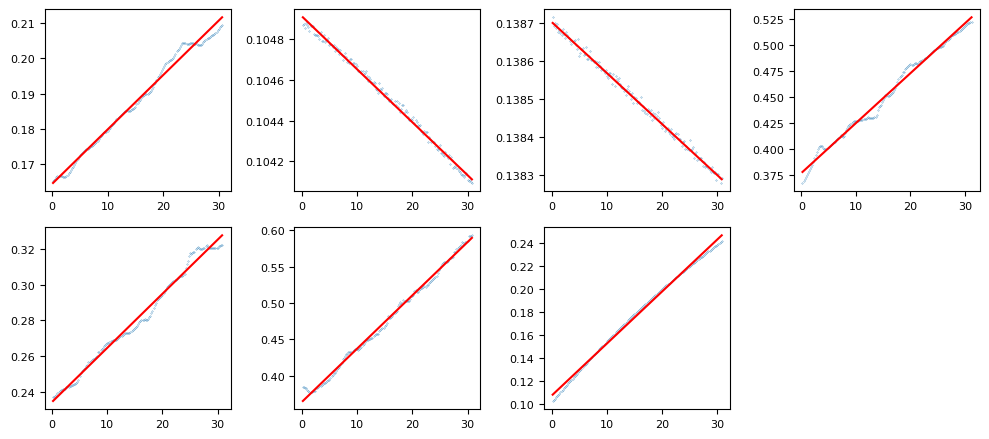

In [32]:
# plotting prediction groups
x_list = []
y_list = []
y_fit_list = []

for idx in rb_n: # CHANGE AS NEEDED
    x, y, y_fit = fit_lin(idx, test_df['Test'])
    x_list.append(x)
    y_list.append(y)
    y_fit_list.append(y_fit)
    
plot_fit(x_list, y_list, y_fit_list)

In [33]:
for test in test_df.loc[n_rb, 'Test']:
    print(test.ID)

10660892
10735355
10735356
10735357
10769397
10769398


In [21]:
### computing R-squared values to evaluate fit
rs_list = []

for y, y_fit in zip(y_list, y_fit_list):
    rs_list.append(compute_residuals(y, y_fit))
    
rs_list.sort() # DO NOT SORT ON FIRST RUN

for r_squared in rs_list:
    print(f"R-squared: {r_squared:.4f}")

"""
# plotting distribution of R-squared values
plt.hist(rs_list, bins='auto', edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of List')

# show the plot
plt.show()
"""

R-squared: 0.7521
R-squared: 0.9777
R-squared: 0.9813
R-squared: 0.9836
R-squared: 0.9892
R-squared: 0.9898
R-squared: 0.9910
R-squared: 0.9910
R-squared: 0.9910
R-squared: 0.9921
R-squared: 0.9924
R-squared: 0.9924
R-squared: 0.9933
R-squared: 0.9942
R-squared: 0.9945
R-squared: 0.9948
R-squared: 0.9949
R-squared: 0.9956
R-squared: 0.9957
R-squared: 0.9957
R-squared: 0.9957
R-squared: 0.9958
R-squared: 0.9959
R-squared: 0.9960
R-squared: 0.9964
R-squared: 0.9967
R-squared: 0.9971
R-squared: 0.9972
R-squared: 0.9972
R-squared: 0.9973
R-squared: 0.9975


"\n# plotting distribution of R-squared values\nplt.hist(rs_list, bins='auto', edgecolor='black')\n\n# add labels and title\nplt.xlabel('Values')\nplt.ylabel('Frequency')\nplt.title('Distribution of List')\n\n# show the plot\nplt.show()\n"

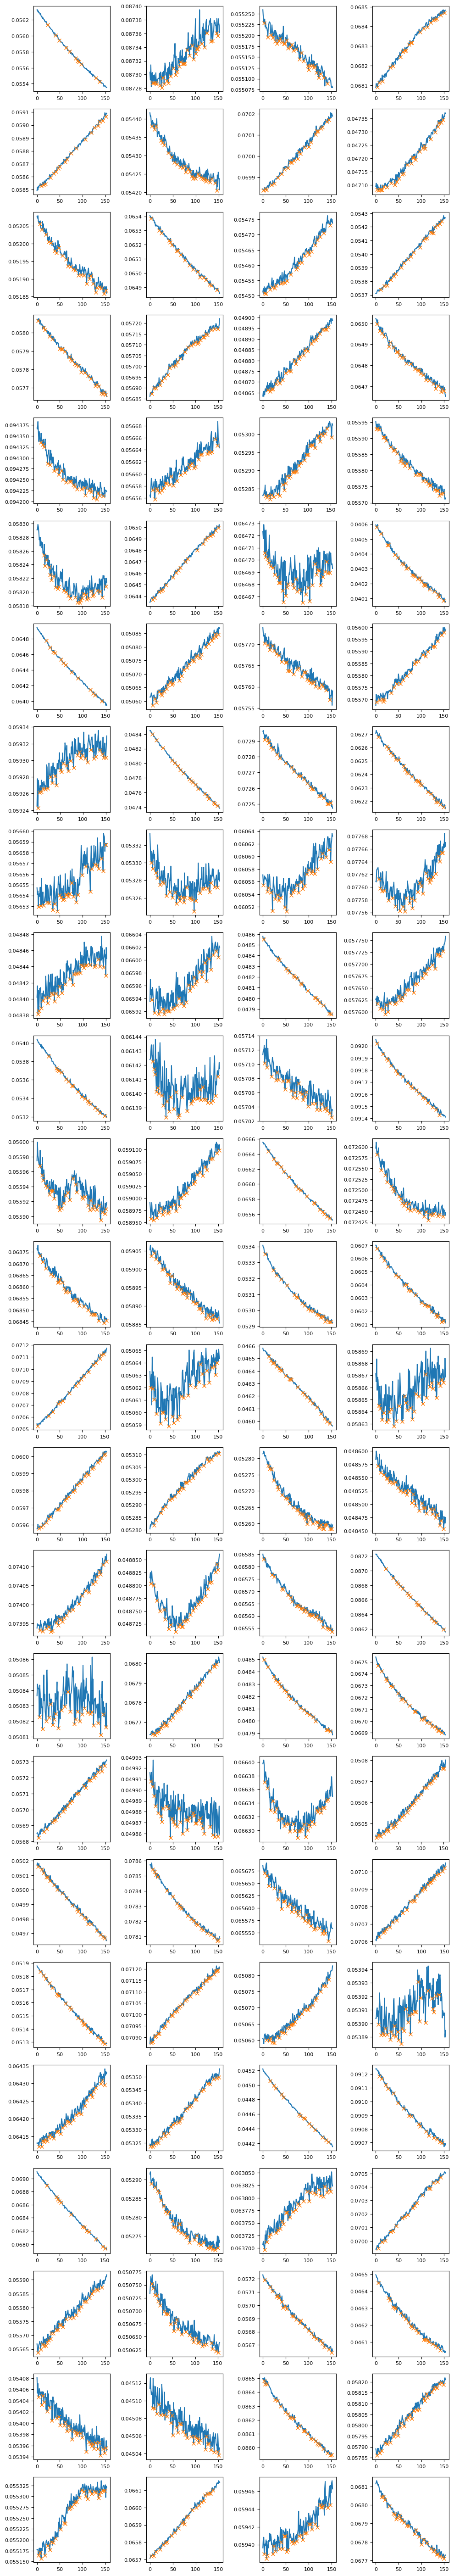

In [18]:
# plotting small peaks
sm_peaks = []
indices = n_rb[:100]

for test in test_df.loc[indices, 'Test']:
    sm_peaks.append(small_peaks(test))
    
target_indices = list(range(len(test_df.loc[indices, 'Test']))) # all
plot_waveforms(target_indices, test_df.loc[indices, 'Test'].values.tolist(), sm_peaks)

In [ ]:
# plotting wide peaks
wd_peaks = []

for test in test_df.loc[rf_rf[100:200], 'Test']:
    wd_peaks.append(wide_peaks(test))
    
target_indices = list(range(len(test_df.loc[rf_rf[100:200], 'Test']))) # all
plot_waveforms(target_indices, test_df.loc[rf_rf[100:200], 'Test'].values.tolist(), wd_peaks)